# Google colab initialization

For Google colab uncomment these lines and run them to access your drive or try the second way (not tested)

In [18]:
# from google.colab import drive
# drive.mount('/content/drive')
# import sys
#
# sys.path.insert(1, r'/content/drive/My Drive/')

In [19]:
# Other try
# !git clone https://github.com/Alexanderstaehle/OM_project

In [20]:
# import sys
# sys.path.append("OM_project")

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.python.keras.models import load_model

from utils import ml_utils, visualization, data_loading, tf_models

In [22]:
RETRAIN_FLAG = True
data_loading.initialize_env()
sns.set_theme()
color_map = sns.color_palette(as_cmap=True)
ml_utils.check_tpu_gpu()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of accelerators:  1


# Different batch sizes with fixed learning rate

In [23]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = 10
filename = 'model_fixed_lr_diff_bs'

## Load previously trained model states

In [24]:
model_history_dict_fixed_lr = {}
model_history_dict_fixed_lr = ml_utils.load_model_state(filename)
if RETRAIN_FLAG:
    model_weights_fixed_lr = {}
    for batch_size in batch_sizes:
        model_weights_fixed_lr[batch_size] = {}
        filepath = 'tmp/weights/batch_size_{}_best_model.h5'.format(batch_size)
        model_weights_fixed_lr[batch_size] = load_model(filepath)

In [25]:
if RETRAIN_FLAG:
    test_results = []
    for batch_size in batch_sizes:
        # Read training data
        train, validation, test = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST',
                                                                                batch_size=batch_size,
                                                                                img_size=32)
        model = tf_models.build_simple_dense_model(train)
        train_callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=10,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(
                'tmp/weights/batch_size_{}_best_model.h5'.format(batch_size),
                monitor='val_loss',
                mode='min',
                verbose=1,
                save_best_only=True,
            )
            # tf.keras.callbacks.ReduceLROnPlateau(
            #     monitor="val_loss", factor=0.5,
            #     patience=3, verbose=1
            # )
        ]
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        # Need sparse categorical crossentropy since our labels are in form of integers not vectors
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model_history_dict_fixed_lr[batch_size] = ml_utils.train_model(model, train, validation, epochs=10,
                                                                       extra_callbacks=train_callbacks, verbose=1)
        loss, acc = model.evaluate(test)
        test_results.append([batch_size, loss, acc])
    test_results = pd.DataFrame(test_results, columns=["Batch_size", "Loss", "Accuracy"]).set_index("Batch_size")

Epoch 1/10
1406/1407 [============================>.] - ETA: 0s - loss: 2.3578 - accuracy: 0.1200    

In [30]:
test_results

,Batch_size,Loss,Accuracy
0,32,2.302583,0.124500
1,64,2.302583,0.114833
2,128,2.302200,0.267833
3,256,2.296829,0.564500
4,512,2.302201,0.194667
5,1024,2.299129,0.628833


In [27]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(model_history_dict_fixed_lr, filename)

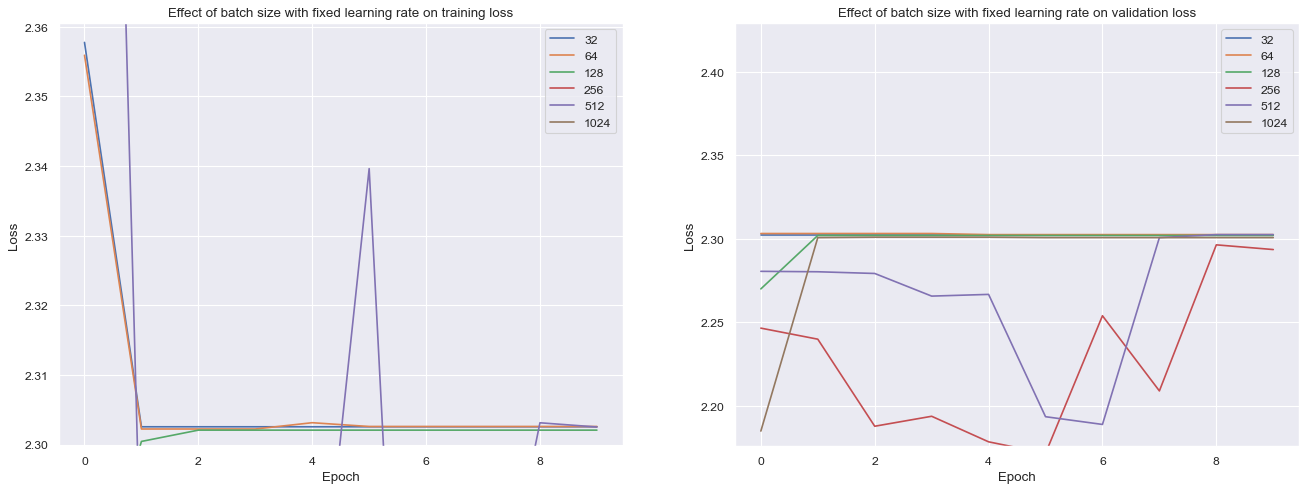

<Figure size 432x288 with 0 Axes>

In [28]:
visualization.plot_loss_by_param(model_history_dict_fixed_lr, 'batch size with fixed learning rate', 'fixed_lr_diff_bs')

# Different batch sizes with linear increasing learning rate

In [29]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = 10
filename = 'model_diff_lr_diff_bs'

## Load previously trained model states

In [ ]:
model_history_dict_diff_lr = {}
model_history_dict_diff_lr = ml_utils.load_model_state(filename)
if RETRAIN_FLAG:
    model_weights_diff_lr = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model_weights_diff_lr[lr] = {}
        filepath = 'tmp/weights/batch_size_{}_lr_{}_best_model.h5'.format(batch_size, lr)
        model_weights_diff_lr[lr] = load_model(filepath)

In [ ]:
if RETRAIN_FLAG:
    test_results = []
    for (batch_size, lr) in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation, test = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST',
                                                                                batch_size=batch_size,
                                                                                img_size=32)
        model = tf_models.build_simple_dense_model(train)
        train_callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=10,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(
                'tmp/weights/batch_size_{}_lr_{}_best_model.h5'.format(batch_size, lr),
                monitor='val_loss',
                mode='min',
                verbose=1,
                save_best_only=True,
            )
            # tf.keras.callbacks.ReduceLROnPlateau(
            #     monitor="val_loss", factor=0.5,
            #     patience=3, verbose=1
            # )
        ]
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        # Need sparse categorical crossentropy since our labels are in form of integers not vectors
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model_history_dict_diff_lr[lr] = ml_utils.train_model(model, train, validation, epochs=10,
                                                              extra_callbacks=train_callbacks, verbose=1)
        loss, acc = model.evaluate(test)
        test_results.append([batch_size, lr, loss, acc])
    test_results = pd.DataFrame(test_results, columns=["Batch_size", "Learning rate", "Loss", "Accuracy"]).set_index(
        "Batch_size")

In [ ]:
test_results

In [ ]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(model_history_dict_diff_lr, filename)

In [ ]:
visualization.plot_loss_by_param(model_history_dict_diff_lr, 'batch size with linear increasing learning rate',
                                 'diff_lr_diff_bs')

# Duration analysis

Taken from [here](https://medium.com/deep-learning-experiments/effect-of-batch-size-on-neural-net-training-c5ae8516e57).

## Fixed learning rate

In [ ]:
mean_times = []
convergence_epochs = []
overall_training_times = []

for batch_size in batch_sizes:
    # Compute mean epoch time, num epochs to converge, overall training time
    state = model_history_dict_fixed_lr[batch_size]
    mean_time_per_epoch = np.mean(state.times)
    convergence_epoch = np.argmin(state.history['val_loss'])
    overall_training_time = np.sum(state.times[:convergence_epoch])

    # Append results
    convergence_epochs.append(convergence_epoch)
    mean_times.append(mean_time_per_epoch)
    overall_training_times.append(overall_training_time)

    print("Batch size: ", batch_size)
    print("\tMean time per epoch: ", mean_time_per_epoch)
    print("\tConverged in {} epochs".format(convergence_epoch))
    print("\tOverall training time (in seconds) until convergence: ", overall_training_time)

In [ ]:

rects = plt.bar(x=range(len(batch_sizes)), height=mean_times, tick_label=batch_sizes)
plt.xlabel('Batch size')
plt.ylabel('Average time per epoch (s)')
plt.ylim(0, 14)
plt.title('Mean training time per epoch by batch size')
plt.show()
plt.savefig('graphs/mean_epoch_training_time_by_batch_size')

In [ ]:
rects = plt.bar(x=range(len(batch_sizes)), height=convergence_epochs, tick_label=batch_sizes)
plt.xlabel('Batch size')
plt.ylabel('Number of training epochs')
plt.ylim(0, 1100)
plt.title('Number of training epochs until convergence')
plt.show()
plt.savefig('graphs/num_training_epochs_by_batch_size')

In [ ]:
rects = plt.bar(x=range(len(batch_sizes)), height=overall_training_times, tick_label=batch_sizes)
plt.xlabel('Batch size')
plt.ylabel('Overall training time (in seconds)')
plt.ylim(0, 8000)
plt.title('Overall training time until convergence, by batch size')
plt.show()
plt.savefig('graphs/overall_training_time_by_batch_size')

## Linearly increasing learning rate

In [ ]:
mean_times = []
convergence_epochs = []
overall_training_times = []

for batch_size, lr in zip(batch_sizes, learning_rates):
    # Compute mean epoch time, num epochs to converge, overall training time
    state = model_history_dict_diff_lr[batch_size]
    mean_time_per_epoch = np.mean(state.times)
    convergence_epoch = np.argmin(state.history['val_loss'])
    overall_training_time = np.sum(state.times[:convergence_epoch])

    # Append results
    convergence_epochs.append(convergence_epoch)
    mean_times.append(mean_time_per_epoch)
    overall_training_times.append(overall_training_time)

    print("Batch size: ", batch_size)
    print("\tMean time per epoch: ", mean_time_per_epoch)
    print("\tConverged in {} epochs".format(convergence_epoch))
    print("\tOverall training time (in seconds) until convergence: ", overall_training_time)

In [ ]:

rects = plt.bar(x=range(len(batch_sizes)), height=mean_times, tick_label=batch_sizes)
plt.xlabel('Batch size')
plt.ylabel('Average time per epoch (s)')
plt.ylim(0, 14)
plt.title('Mean training time per epoch by batch size')
plt.show()
plt.savefig('graphs/mean_epoch_training_time_by_batch_size')

In [ ]:
rects = plt.bar(x=range(len(batch_sizes)), height=convergence_epochs, tick_label=batch_sizes)
plt.xlabel('Batch size')
plt.ylabel('Number of training epochs')
plt.ylim(0, 1100)
plt.title('Number of training epochs until convergence')
plt.show()
plt.savefig('graphs/num_training_epochs_by_batch_size')

In [ ]:
rects = plt.bar(x=range(len(batch_sizes)), height=overall_training_times, tick_label=batch_sizes)
plt.xlabel('Batch size')
plt.ylabel('Overall training time (in seconds)')
plt.ylim(0, 8000)
plt.title('Overall training time until convergence, by batch size')
plt.show()
plt.savefig('graphs/overall_training_time_by_batch_size')